In [1]:
%matplotlib inline
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
plt.ion()   # interactive mode
from scipy.misc import imread, imresize

In [2]:
################## TRAIN ##############################
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                try:
                    img = resize_image(img, size)
                    img.save(os.path.join(output_dir, image), img.format)
                except:
                    print("Cannot read image")
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))
image_dir = './skin_cancer_data/train/benign/'        
output_dir = './resized/train/benign/'
image_size = [224, 224]
resize_images(image_dir, output_dir, image_size)

[100/1922] Resized the images and saved into './resized/train/benign/'.
[200/1922] Resized the images and saved into './resized/train/benign/'.
[300/1922] Resized the images and saved into './resized/train/benign/'.
[400/1922] Resized the images and saved into './resized/train/benign/'.
[500/1922] Resized the images and saved into './resized/train/benign/'.
[600/1922] Resized the images and saved into './resized/train/benign/'.
[700/1922] Resized the images and saved into './resized/train/benign/'.
[800/1922] Resized the images and saved into './resized/train/benign/'.
[900/1922] Resized the images and saved into './resized/train/benign/'.
[1000/1922] Resized the images and saved into './resized/train/benign/'.
[1100/1922] Resized the images and saved into './resized/train/benign/'.
[1200/1922] Resized the images and saved into './resized/train/benign/'.
[1300/1922] Resized the images and saved into './resized/train/benign/'.
[1400/1922] Resized the images and saved into './resized/tra

In [3]:
################## TRAIN ##############################

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),}

data_dir = 'skin_cancer_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
################## TRAIN ##############################
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

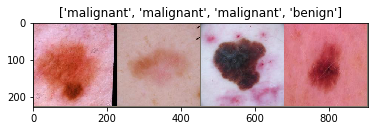

In [5]:
################## TRAIN ##############################

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
################## TRAIN ##############################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
################## TRAIN ##############################
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
################## TRAIN ##############################
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
################## TRAIN ##############################
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
torch.save(model_ft.state_dict(), 'skin_cancer_model.pth.tar')

Epoch 0/24
----------


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('skin_cancer_model.pth.tar'))
class_names = ['benign', 'malignant']

In [ ]:
################## TRAIN ##############################
model_ft.eval()
visualize_model(model_ft)

In [ ]:
def predict_single_image(class_names, model_ft, image):
    img = imread(image)
    img = imresize(img, (224, 224))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    img = transform(img)  # (3, 224, 224)
    img = img.unsqueeze(0)  # (1, 3, 224, 224)
    model_ft.eval()
    with torch.no_grad():
        outputs = model_ft(img)
        _, preds = torch.max(outputs, 1)
        print("predicted: {}".format(class_names[preds]))
        

In [ ]:
predict_single_image(class_names, model_ft, 'test.jpg')